In [1]:
#Data download and preprocessing

import yfinance as yf     # i used here the yahoo finance library for stock price dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Dataset Downloading

In [2]:
# Parameters

TICKER = 'AAPL'         # "AAPL" is the stock ticker symbol for Apple Inc data
START = '2015-01-01'    #start date for downloading historical data
END = None              # till today's date

# Download data and select 'Close' column

df = yf.download(TICKER, start=START, end=END, progress=False)
df = df[['Close']].dropna()

# Ensuring the index is a DatetimeIndex and rename the column

df.index = pd.to_datetime(df.index)
df.rename(columns={'Close':'close'}, inplace=True)

df.tail()

/tmp/ipython-input-993671370.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START, end=END, progress=False)


Price,close
Ticker,AAPL
Date,
2025-09-26,255.460007
2025-09-29,254.429993
2025-09-30,254.630005
2025-10-01,255.449997
2025-10-02,257.130005


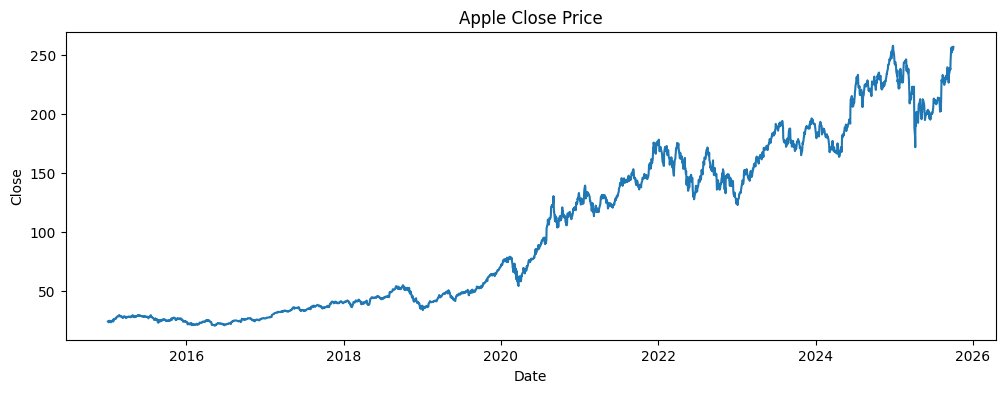

In [3]:
# Plot

plt.figure(figsize=(12,4))
plt.plot(df.index, df['close'])
plt.title('Apple Close Price')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()



In [4]:
# Save a CSV copy

df.to_csv('orig_stock_close_price.csv')


In [5]:
# Preparing series and train/test splits

series = df['close']

test_len = 180 # last 180 days as test for baseline
train, test = series[:-test_len], series[-test_len:]
print('Train length:', len(train), 'Test length:', len(test))

Train length: 2524 Test length: 180


Traditional Statistical Model

In [6]:
# ARIMA (using statsmodels)

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math

In [8]:
# Fitting ARIMA

arima_model = ARIMA(train, order=(5,1,0))   # (p,d,q)
arima_fit = arima_model.fit()

arima_fit.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   AAPL   No. Observations:                 2524
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5238.776
Date:                Fri, 03 Oct 2025   AIC                          10489.553
Time:                        04:47:41   BIC                          10524.552
Sample:                             0   HQIC                         10502.253
                               - 2524                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0091      0.013     -0.710      0.477      -0.034       0.016
ar.L2         -0.0205      0.014     -1.491      0.136      -0.047       0.006
ar.L3         -0.0198      0.014     -1.373      0.170      -0.048       0.008
ar.L4          0.0120      0.013      0.919      0.358      -0.014       0.038
ar.L5          0.0187      0.013      1.425      0.154      -0.007       0.044
sigma2         3.7245      0.054     69.337      0.000       3.619       3.830
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              3870.50
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              41.66   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
# Forecast

n_forecast = len(test)
arima_forecast = arima_fit.forecast(steps=n_forecast)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [12]:
# Fine-tuning the order  (p,d,q)


import itertools
import warnings
warnings.filterwarnings("ignore")


# ARIMA tuning function
def tune_arima(series, p_range=range(0,6), d_range=range(0,3), q_range=range(0,6),
               method='aic', cv_horizon=30, verbose=True):
    best_score = float("inf")
    best_order = None

    for order in itertools.product(p_range, d_range, q_range):
        try:
            if method in ['aic','bic']:
                model = ARIMA(series, order=order)
                model_fit = model.fit()
                score = model_fit.aic if method=='aic' else model_fit.bic
            elif method=='cv':
                errors = []
                for i in range(cv_horizon, len(series)):
                    train_cv = series[:i]
                    test_cv = series[i:i+1]
                    if len(test_cv)==0:
                        break
                    model = ARIMA(train_cv, order=order)
                    model_fit = model.fit()
                    pred = model_fit.forecast(steps=1)
                    errors.append((test_cv.values[0]-pred.values[0])**2)
                score = math.sqrt(sum(errors)/len(errors))
            else:
                raise ValueError("method must be 'aic','bic', or 'cv'")

            if score < best_score:
                best_score = score
                best_order = order

            if verbose:
                print(f"Tested order {order} → score: {score:.2f}")

        except Exception as e:
            if verbose:
                print(f"Skipping order {order} due to error: {e}")
            continue

    return {'order': best_order, 'score': best_score}



In [13]:
# RMSE function
def rmse(a,b):
    return math.sqrt(mean_squared_error(a,b))

# Auto-tune ARIMA using AIC
print("Tuning ARIMA based on AIC...")
best_arima = tune_arima(train, method='aic', verbose=True)
print("Best ARIMA order:", best_arima['order'], "AIC:", best_arima['score'])

# Fit final ARIMA with best order
arima_fit = ARIMA(train, order=best_arima['order']).fit()

# Forecast test period
arima_forecast = arima_fit.forecast(steps=len(test))
arima_forecast = pd.Series(arima_forecast.values, index=test.index)

# Evaluate metrics
arima_rmse = rmse(test, arima_forecast)
arima_mape = mean_absolute_percentage_error(test, arima_forecast)
print('ARIMA RMSE:', arima_rmse, 'MAPE:', arima_mape)


Tuning ARIMA based on AIC...
Tested order (0, 0, 0) → score: 28308.30
Tested order (0, 0, 1) → score: 24909.38
Tested order (0, 0, 2) → score: 22051.49
Tested order (0, 0, 3) → score: 19740.74
Tested order (0, 0, 4) → score: 18263.61
Tested order (0, 0, 5) → score: 16861.25
Tested order (0, 1, 0) → score: 10483.11
Tested order (0, 1, 1) → score: 10484.92
Tested order (0, 1, 2) → score: 10485.81
Tested order (0, 1, 3) → score: 10486.90
Tested order (0, 1, 4) → score: 10488.36
Tested order (0, 1, 5) → score: 10489.52
Tested order (0, 2, 0) → score: 12249.11
Tested order (0, 2, 1) → score: 10485.20
Tested order (0, 2, 2) → score: 10486.92
Tested order (0, 2, 3) → score: 10487.63
Tested order (0, 2, 4) → score: 10488.54
Tested order (0, 2, 5) → score: 10490.12
Tested order (1, 0, 0) → score: 10498.98
Tested order (1, 0, 1) → score: 10500.80
Tested order (1, 0, 2) → score: 10501.71
Tested order (1, 0, 3) → score: 10502.82
Tested order (1, 0, 4) → score: 10504.26
Tested order (1, 0, 5) → sco

In [10]:
# Forecast same length as test

n_forecast = len(test)
arima_forecast = arima_fit.forecast(steps=n_forecast)
arima_forecast = pd.Series(arima_forecast, index=test.index)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [14]:
print("NaNs in test:", test.isna().sum())
print("NaNs in forecast:", pd.isna(arima_forecast).sum())


NaNs in test: Ticker
AAPL    0
dtype: int64
NaNs in forecast: 0


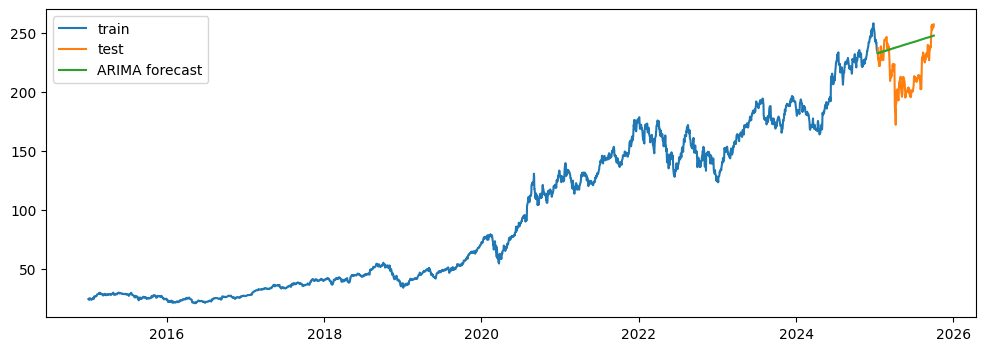

In [15]:
# Lebelling the forecast

train.index = pd.DatetimeIndex(train.index)
test.index = pd.DatetimeIndex(test.index)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(train.index, train, label='train')
plt.plot(test.index, test, label='test')
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA forecast')
plt.legend()
plt.show()




Prophet Model

In [16]:
# Prophet (Facebook Prophet)

from prophet import Prophet

In [17]:
# Preparing DataFrame for Prophet model

prophet_df = train.copy().reset_index()
prophet_df.columns = ['ds', 'y']

In [18]:
# Ensuring correct types

prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])
prophet_df['y'] = pd.to_numeric(prophet_df['y'], errors='coerce')

In [19]:
# Droping any NaNs just in case

prophet_df = prophet_df.dropna(subset=['ds','y'])

prophet_df.head()

,ds,y
0,2015-01-02,24.261049
1,2015-01-05,23.577568
2,2015-01-06,23.579792
3,2015-01-07,23.910431
4,2015-01-08,24.829124


In [20]:
# Initialize and fitting Prophet

m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp26g32_oh/q0s_cfcj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26g32_oh/vrmp23wc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59064', 'data', 'file=/tmp/tmp26g32_oh/q0s_cfcj.json', 'init=/tmp/tmp26g32_oh/vrmp23wc.json', 'output', 'file=/tmp/tmp26g32_oh/prophet_modeltnx1drg9/prophet_model-20251003053719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:37:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:37:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [21]:
future = m.make_future_dataframe(periods=len(test), freq='D')
forecast = m.predict(future)

# Align forecast with test set
prophet_forecast = forecast.set_index('ds').reindex(test.index)['yhat'].fillna(method='ffill')


In [22]:
# Evaluation for Prophet

def rmse(a, b):
    import math
    from sklearn.metrics import mean_squared_error
    return math.sqrt(mean_squared_error(a, b))

from sklearn.metrics import mean_absolute_percentage_error
prophet_rmse = rmse(test, prophet_forecast)
prophet_mape = mean_absolute_percentage_error(test, prophet_forecast)
print('Prophet RMSE:', prophet_rmse, 'MAPE:', prophet_mape)

Prophet RMSE: 32.9969312717412 MAPE: 0.13469544477594175


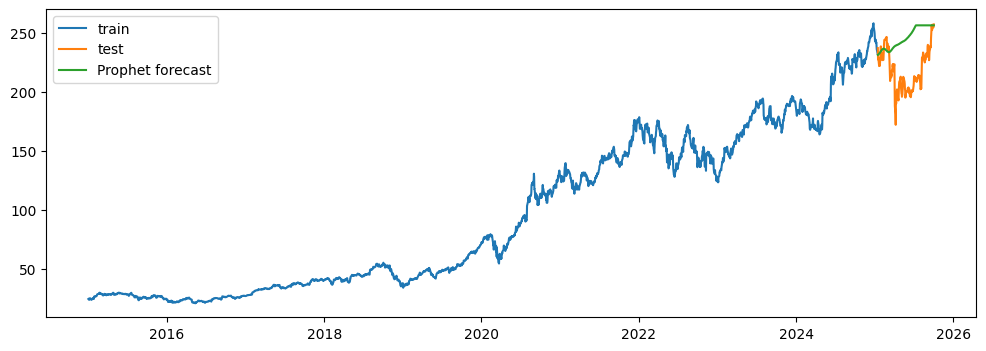

In [23]:
# Plot  for Prophet Model

plt.figure(figsize=(12,4))
plt.plot(train.index, train, label='train')
plt.plot(test.index, test, label='test')
plt.plot(prophet_forecast.index, prophet_forecast, label='Prophet forecast')
plt.legend()
plt.show()

LSTM Model

In [24]:
# LSTM

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

#Scale the series
scaler = MinMaxScaler(feature_range=(0,1))
scaled_series = scaler.fit_transform(series.values.reshape(-1,1))

# Function to create sliding windows
def create_windows(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i,0])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 3D input for LSTM
    return X, y

window_size = 60

# train/test datasets
X_all, y_all = create_windows(scaled_series, window_size=window_size)

# Determine split index for train/test
split_index = len(train) - window_size
X_train, y_train = X_all[:split_index], y_all[:split_index]
X_test, y_test = X_all[split_index:], y_all[split_index:]

print('LSTM X_train shape:', X_train.shape, 'X_test shape:', X_test.shape)

# Build the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size,1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Predict on test data
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)

# Align predictions with test index
lstm_forecast = pd.Series(pred.flatten(), index=test.index[:len(pred)])

# Evaluation
from sklearn.metrics import mean_absolute_percentage_error

lstm_rmse = rmse(test[:len(pred)], lstm_forecast)
lstm_mape = mean_absolute_percentage_error(test[:len(pred)], lstm_forecast)
print('LSTM RMSE:', lstm_rmse, 'MAPE:', lstm_mape)




LSTM X_train shape: (2464, 60, 1) X_test shape: (180, 60, 1)
Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.0216 - val_loss: 8.9843e-04
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0015 - val_loss: 0.0082
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0013 - val_loss: 0.0056
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0014 - val_loss: 7.6957e-04
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0012 - val_loss: 7

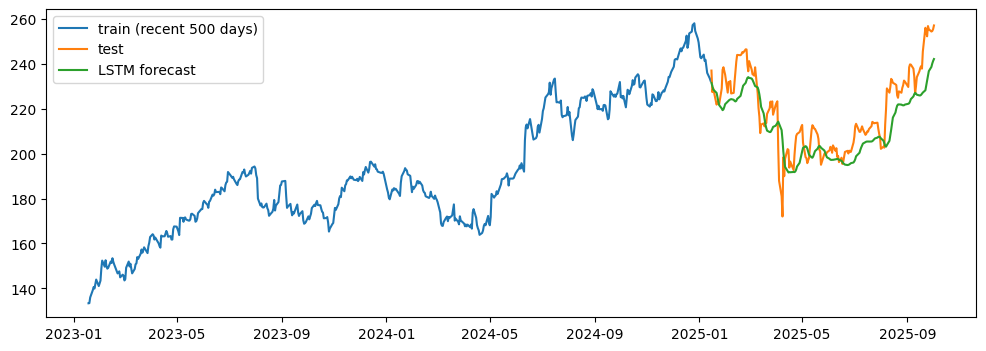

In [25]:
# Plot results for LSTM

plt.figure(figsize=(12,4))
plt.plot(train.index[-500:], train[-500:], label='train (recent 500 days)')
plt.plot(test.index, test, label='test')
plt.plot(lstm_forecast.index, lstm_forecast, label='LSTM forecast')
plt.legend()
plt.show()

Rolling Window Evaluation

In [26]:
# Rolling window evaluation using statsmodels ARIMA

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

def rolling_forecast_arima_sm(series, initial_train_period=1000, horizon=1, max_rounds=50, order=(5,1,0), verbose=False):
    forecasts = []
    indices = []
    start = initial_train_period
    rounds = 0

    iterator = range(max_rounds) if not verbose else tqdm(range(max_rounds), desc="Rolling ARIMA (statsmodels)")

    while start + horizon <= len(series) and rounds < max_rounds:
        train = series[:start]
        test_slice = series[start:start+horizon]

        try:
            model = ARIMA(train, order=order)
            model_fit = model.fit()
            pred = model_fit.forecast(steps=horizon)
        except Exception as e:
            if verbose:
                print(f"ARIMA fit failed at round {rounds}: {e}")
            pred = [float('nan')] * horizon

        forecasts.extend(pred)
        indices.extend(test_slice.index)
        start += horizon
        rounds += 1

    return pd.Series(forecasts, index=indices)


 Performance Comparison Table

In [27]:
# Performance table and report (gather metrics)

import pandas as pd

# Collect metrics in a dictionary

metrics = {
    'ARIMA': {'RMSE': arima_rmse, 'MAPE': arima_mape},
    'Prophet': {'RMSE': prophet_rmse, 'MAPE': prophet_mape},
    'LSTM': {'RMSE': lstm_rmse, 'MAPE': lstm_mape}
}

metrics_df = pd.DataFrame(metrics).T

metrics_df.fillna('-', inplace=True)

metrics_df.sort_values(by='RMSE', inplace=True)

display(metrics_df)

# Save to CSV
metrics_df.to_csv('performance_table_all_models.csv', index=True)


,RMSE,MAPE
LSTM,11.054235,0.040274
ARIMA,27.595965,0.112385
Prophet,32.996931,0.134695
